## Dependencias

In [272]:
import pandas as pd
import numpy as np
import numpy as np
import gudhi as gd  
from sklearn import manifold
from pylab import *
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud
from gtda.time_series import SingleTakensEmbedding
from gtda.homology import VietorisRipsPersistence
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from sklearn.model_selection import train_test_split
import keras
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn
from keras.callbacks import EarlyStopping
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn import preprocessing

%matplotlib inline
# import sklearn_tda


### Importar datos

In [273]:
object=pd.read_pickle('uke_eggedal_data_challenge.pkl')
df=pd.DataFrame.from_dict(object,orient='index')

In [274]:
df=df.T
df

,flow,obs_tas,flow_dates,obs_lon_lat,obs_pr,obs_dates
0,1.723781,"[-10.600000381469727, -9.699999809265137, -6.6...",1958-01-04,9.37,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10000000...",1957-01-01
1,0.960882,"[-20.5, -19.100000381469727, -12.0, -17.700000...",1958-01-05,60.23,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20000000...",1957-01-02
2,0.001,"[-23.600000381469727, -22.5, -15.1000003814697...",1958-01-06,None,"[0.10000000149011612, 0.0, 0.30000001192092896...",1957-01-03
3,0.001,"[-16.200000762939453, -16.0, -14.1000003814697...",1958-01-07,None,"[1.0, 0.0, 1.0, 1.100000023841858, 0.899999976...",1957-01-04
4,0.316796,"[-7.900000095367432, -7.800000190734863, -9.5,...",1958-01-08,None,"[9.300000190734863, 8.600000381469727, 8.0, 8....",1957-01-05
...,...,...,...,...,...,...
21541,1.812796,"[-12.5, -11.699999809265137, -8.60000038146972...",2016-12-26,None,"[2.200000047683716, 0.10000000149011612, 1.100...",2015-12-27
21542,None,"[-12.5, -11.899999618530273, -9.10000038146972...",NaT,None,"[5.5, 4.900000095367432, 8.300000190734863, 6....",2015-12-28
21543,None,"[-11.899999618530273, -11.399999618530273, -8....",NaT,None,"[1.7999999523162842, 1.7000000476837158, 2.099...",2015-12-29
21544,None,"[-7.0, -6.5, -3.4000000953674316, -5.900000095...",NaT,None,"[4.099999904632568, 3.5, 4.599999904632568, 5....",2015-12-30


### Hay un desface en la data, se separan en df_target y df predic, se usa merge con date como llave

In [275]:
df_target=df[['flow_dates','flow']]
df_target.sort_values(by='flow_dates')
df_target=df_target.dropna()
df_target

,flow_dates,flow
0,1958-01-04,1.723781
1,1958-01-05,0.960882
2,1958-01-06,0.001
3,1958-01-07,0.001
4,1958-01-08,0.316796
...,...,...
21537,2016-12-22,4.84329
21538,2016-12-23,3.75697
21539,2016-12-24,3.556818
21540,2016-12-25,3.402133


In [276]:
df_predic=df[['obs_dates','obs_tas','obs_pr']]
df_predic.sort_values(by='obs_dates')
df_predic=df_predic.dropna()
df_predic


,obs_dates,obs_tas,obs_pr
0,1957-01-01,"[-10.600000381469727, -9.699999809265137, -6.6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10000000..."
1,1957-01-02,"[-20.5, -19.100000381469727, -12.0, -17.700000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20000000..."
2,1957-01-03,"[-23.600000381469727, -22.5, -15.1000003814697...","[0.10000000149011612, 0.0, 0.30000001192092896..."
3,1957-01-04,"[-16.200000762939453, -16.0, -14.1000003814697...","[1.0, 0.0, 1.0, 1.100000023841858, 0.899999976..."
4,1957-01-05,"[-7.900000095367432, -7.800000190734863, -9.5,...","[9.300000190734863, 8.600000381469727, 8.0, 8...."
...,...,...,...
21541,2015-12-27,"[-12.5, -11.699999809265137, -8.60000038146972...","[2.200000047683716, 0.10000000149011612, 1.100..."
21542,2015-12-28,"[-12.5, -11.899999618530273, -9.10000038146972...","[5.5, 4.900000095367432, 8.300000190734863, 6...."
21543,2015-12-29,"[-11.899999618530273, -11.399999618530273, -8....","[1.7999999523162842, 1.7000000476837158, 2.099..."
21544,2015-12-30,"[-7.0, -6.5, -3.4000000953674316, -5.900000095...","[4.099999904632568, 3.5, 4.599999904632568, 5...."


### Se hace el merge tomando como llaves las fechas, el resultado es un df con fechas que ya hacen match

In [277]:
df_final=df_predic.merge(df_target,how='inner',left_on='obs_dates',right_on='flow_dates')
df_final

,obs_dates,obs_tas,obs_pr,flow_dates,flow
0,1958-01-04,"[-12.800000190734863, -13.0, -13.0, -12.5, -12...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1958-01-04,1.723781
1,1958-01-05,"[-7.800000190734863, -7.900000095367432, -8.39...","[2.0, 2.200000047683716, 3.0, 3.29999995231628...",1958-01-05,0.960882
2,1958-01-06,"[-11.0, -9.899999618530273, -6.5, -8.5, -9.0, ...","[12.699999809265137, 11.0, 16.5, 12.5, 11.1999...",1958-01-06,0.001
3,1958-01-07,"[-13.199999809265137, -12.199999809265137, -7....","[6.599999904632568, 6.900000095367432, 9.60000...",1958-01-07,0.001
4,1958-01-08,"[-19.899999618530273, -19.299999237060547, -15...","[3.4000000953674316, 3.5999999046325684, 2.700...",1958-01-08,0.316796
...,...,...,...,...,...
21173,2015-12-27,"[-12.5, -11.699999809265137, -8.60000038146972...","[2.200000047683716, 0.10000000149011612, 1.100...",2015-12-27,2.17704
21174,2015-12-28,"[-12.5, -11.899999618530273, -9.10000038146972...","[5.5, 4.900000095367432, 8.300000190734863, 6....",2015-12-28,4.87625
21175,2015-12-29,"[-11.899999618530273, -11.399999618530273, -8....","[1.7999999523162842, 1.7000000476837158, 2.099...",2015-12-29,4.99884
21176,2015-12-30,"[-7.0, -6.5, -3.4000000953674316, -5.900000095...","[4.099999904632568, 3.5, 4.599999904632568, 5....",2015-12-30,4.428777


### Climate AI sugiere usar o PCA o simplemente promediar los datos vectorizados en lugar de tratarlos como variables distintas

In [278]:
df_final['temperatures'] = df_final['obs_tas'].apply(lambda x: np.mean(x))
df_final

,obs_dates,obs_tas,obs_pr,flow_dates,flow,temperatures
0,1958-01-04,"[-12.800000190734863, -13.0, -13.0, -12.5, -12...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1958-01-04,1.723781,-12.655556
1,1958-01-05,"[-7.800000190734863, -7.900000095367432, -8.39...","[2.0, 2.200000047683716, 3.0, 3.29999995231628...",1958-01-05,0.960882,-7.722222
2,1958-01-06,"[-11.0, -9.899999618530273, -6.5, -8.5, -9.0, ...","[12.699999809265137, 11.0, 16.5, 12.5, 11.1999...",1958-01-06,0.001,-8.088889
3,1958-01-07,"[-13.199999809265137, -12.199999809265137, -7....","[6.599999904632568, 6.900000095367432, 9.60000...",1958-01-07,0.001,-10.122222
4,1958-01-08,"[-19.899999618530273, -19.299999237060547, -15...","[3.4000000953674316, 3.5999999046325684, 2.700...",1958-01-08,0.316796,-17.455555
...,...,...,...,...,...,...
21173,2015-12-27,"[-12.5, -11.699999809265137, -8.60000038146972...","[2.200000047683716, 0.10000000149011612, 1.100...",2015-12-27,2.17704,-9.944444
21174,2015-12-28,"[-12.5, -11.899999618530273, -9.10000038146972...","[5.5, 4.900000095367432, 8.300000190734863, 6....",2015-12-28,4.87625,-10.288889
21175,2015-12-29,"[-11.899999618530273, -11.399999618530273, -8....","[1.7999999523162842, 1.7000000476837158, 2.099...",2015-12-29,4.99884,-9.411111
21176,2015-12-30,"[-7.0, -6.5, -3.4000000953674316, -5.900000095...","[4.099999904632568, 3.5, 4.599999904632568, 5....",2015-12-30,4.428777,-5.055556


In [279]:
df_final['precipitations'] = df_final['obs_pr'].apply(lambda x: np.mean(x))
df_final

,obs_dates,obs_tas,obs_pr,flow_dates,flow,temperatures,precipitations
0,1958-01-04,"[-12.800000190734863, -13.0, -13.0, -12.5, -12...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1958-01-04,1.723781,-12.655556,0.000000
1,1958-01-05,"[-7.800000190734863, -7.900000095367432, -8.39...","[2.0, 2.200000047683716, 3.0, 3.29999995231628...",1958-01-05,0.960882,-7.722222,2.588889
2,1958-01-06,"[-11.0, -9.899999618530273, -6.5, -8.5, -9.0, ...","[12.699999809265137, 11.0, 16.5, 12.5, 11.1999...",1958-01-06,0.001,-8.088889,12.766667
3,1958-01-07,"[-13.199999809265137, -12.199999809265137, -7....","[6.599999904632568, 6.900000095367432, 9.60000...",1958-01-07,0.001,-10.122222,6.877778
4,1958-01-08,"[-19.899999618530273, -19.299999237060547, -15...","[3.4000000953674316, 3.5999999046325684, 2.700...",1958-01-08,0.316796,-17.455555,3.411111
...,...,...,...,...,...,...,...
21173,2015-12-27,"[-12.5, -11.699999809265137, -8.60000038146972...","[2.200000047683716, 0.10000000149011612, 1.100...",2015-12-27,2.17704,-9.944444,0.555556
21174,2015-12-28,"[-12.5, -11.899999618530273, -9.10000038146972...","[5.5, 4.900000095367432, 8.300000190734863, 6....",2015-12-28,4.87625,-10.288889,4.888889
21175,2015-12-29,"[-11.899999618530273, -11.399999618530273, -8....","[1.7999999523162842, 1.7000000476837158, 2.099...",2015-12-29,4.99884,-9.411111,1.277778
21176,2015-12-30,"[-7.0, -6.5, -3.4000000953674316, -5.900000095...","[4.099999904632568, 3.5, 4.599999904632568, 5....",2015-12-30,4.428777,-5.055556,3.444444


## Normalización de datos, esto reduce la varianza y hace más sencillo interpretar los datos obtenidos al usar IA

In [280]:
df_final['precipitations'] = df_final['precipitations'] /df_final['precipitations'].abs().max()
df_final['temperatures'] = df_final['temperatures'] /df_final['temperatures'].abs().max()
df_final['flow'] = df_final['flow'] /df_final['flow'].abs().max()
df_final

,obs_dates,obs_tas,obs_pr,flow_dates,flow,temperatures,precipitations
0,1958-01-04,"[-12.800000190734863, -13.0, -13.0, -12.5, -12...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1958-01-04,0.020185,-0.389269,0.000000
1,1958-01-05,"[-7.800000190734863, -7.900000095367432, -8.39...","[2.0, 2.200000047683716, 3.0, 3.29999995231628...",1958-01-05,0.011252,-0.237526,0.041093
2,1958-01-06,"[-11.0, -9.899999618530273, -6.5, -8.5, -9.0, ...","[12.699999809265137, 11.0, 16.5, 12.5, 11.1999...",1958-01-06,0.000012,-0.248804,0.202646
3,1958-01-07,"[-13.199999809265137, -12.199999809265137, -7....","[6.599999904632568, 6.900000095367432, 9.60000...",1958-01-07,0.000012,-0.311347,0.109171
4,1958-01-08,"[-19.899999618530273, -19.299999237060547, -15...","[3.4000000953674316, 3.5999999046325684, 2.700...",1958-01-08,0.00371,-0.536910,0.054145
...,...,...,...,...,...,...,...
21173,2015-12-27,"[-12.5, -11.699999809265137, -8.60000038146972...","[2.200000047683716, 0.10000000149011612, 1.100...",2015-12-27,0.025493,-0.305878,0.008818
21174,2015-12-28,"[-12.5, -11.899999618530273, -9.10000038146972...","[5.5, 4.900000095367432, 8.300000190734863, 6....",2015-12-28,0.057101,-0.316473,0.077601
21175,2015-12-29,"[-11.899999618530273, -11.399999618530273, -8....","[1.7999999523162842, 1.7000000476837158, 2.099...",2015-12-29,0.058536,-0.289474,0.020282
21176,2015-12-30,"[-7.0, -6.5, -3.4000000953674316, -5.900000095...","[4.099999904632568, 3.5, 4.599999904632568, 5....",2015-12-30,0.051861,-0.155502,0.054674


In [281]:
clusterized=df_final.drop(['obs_tas','obs_pr','flow_dates'],axis=1)
clusterized

,obs_dates,flow,temperatures,precipitations
0,1958-01-04,0.020185,-0.389269,0.000000
1,1958-01-05,0.011252,-0.237526,0.041093
2,1958-01-06,0.000012,-0.248804,0.202646
3,1958-01-07,0.000012,-0.311347,0.109171
4,1958-01-08,0.00371,-0.536910,0.054145
...,...,...,...,...
21173,2015-12-27,0.025493,-0.305878,0.008818
21174,2015-12-28,0.057101,-0.316473,0.077601
21175,2015-12-29,0.058536,-0.289474,0.020282
21176,2015-12-30,0.051861,-0.155502,0.054674


# Promedios móviles

In [282]:
def movingMeans(df: pd.DataFrame,periods: int) -> pd.DataFrame:
  '''Calcula el promedio movil a n periodos de las variables predictoras'''
  col_name='MM '+str(periods)+' periods'
  df['temperatures '+col_name]=None
  df['precipitations '+col_name]=None
  j=0
  for i in range(periods,len(df)):
    df['temperatures '+col_name][i]=df['temperatures'].iloc[j:i].mean()
    df['precipitations '+col_name][i]=df['precipitations'].iloc[j:i].mean()
    j+=1
  return df


Calculamos medias moviles a 3, 7, 10 y 30 dias

In [283]:
clusterizedMM=movingMeans(clusterized,7)
clusterizedMM=movingMeans(clusterized,3)
clusterizedMM=movingMeans(clusterized,10)
clusterizedMM=movingMeans(clusterized,30)
clusterizedMM

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,obs_dates,flow,temperatures,precipitations,temperatures MM 7 periods,precipitations MM 7 periods,temperatures MM 3 periods,precipitations MM 3 periods,temperatures MM 10 periods,precipitations MM 10 periods,temperatures MM 30 periods,precipitations MM 30 periods
0,1958-01-04,0.020185,-0.389269,0.000000,None,None,None,None,None,None,None,None
1,1958-01-05,0.011252,-0.237526,0.041093,None,None,None,None,None,None,None,None
2,1958-01-06,0.000012,-0.248804,0.202646,None,None,None,None,None,None,None,None
3,1958-01-07,0.000012,-0.311347,0.109171,None,None,-0.291866,0.081246,None,None,None,None
4,1958-01-08,0.00371,-0.536910,0.054145,None,None,-0.265892,0.117637,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
21173,2015-12-27,0.025493,-0.305878,0.008818,0.047798,0.013908,0.010481,0.016814,0.016234,0.019718,-0.031841,0.025379
21174,2015-12-28,0.057101,-0.316473,0.077601,-0.010399,0.014336,-0.090795,0.015697,0.006494,0.015873,-0.041365,0.025673
21175,2015-12-29,0.058536,-0.289474,0.020282,-0.074504,0.025094,-0.218729,0.028807,-0.022522,0.018377,-0.055594,0.026678
21176,2015-12-30,0.051861,-0.155502,0.054674,-0.124646,0.027866,-0.303942,0.035567,-0.057724,0.020406,-0.063876,0.024198


# Derivadas discretas

In [284]:
def finiteDif(df: pd.DataFrame, order: int=1)-> pd.DataFrame:
  '''Calcula la n-esima derivada discreta de las columnas predictoras'''
  tDifs=np.diff(df['temperatures'].iloc[0:len(df)],order)
  pDifs=np.diff(df['precipitations'].iloc[0:len(df)],order)
  col_name=str(order)+'nt derivative'
  df['temperatures '+col_name]=None
  df['precipitations '+col_name]=None
  df['precipitations '+col_name][order:len(df)]=pDifs
  df['temperatures '+col_name][order:len(df)]=tDifs
  return df

Calculamos primera y segunda derivada discreta de las variables predictoras

In [285]:
clusterizedMMDIFS=finiteDif(clusterizedMM,1)
clusterizedMMDIFS=finiteDif(clusterizedMM,2)
clusterizedMMDIFS

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,obs_dates,flow,temperatures,precipitations,temperatures MM 7 periods,precipitations MM 7 periods,temperatures MM 3 periods,precipitations MM 3 periods,temperatures MM 10 periods,precipitations MM 10 periods,temperatures MM 30 periods,precipitations MM 30 periods,temperatures 1nt derivative,precipitations 1nt derivative,temperatures 2nt derivative,precipitations 2nt derivative
0,1958-01-04,0.020185,-0.389269,0.000000,None,None,None,None,None,None,None,None,None,None,None,None
1,1958-01-05,0.011252,-0.237526,0.041093,None,None,None,None,None,None,None,None,0.151743,0.041093,None,None
2,1958-01-06,0.000012,-0.248804,0.202646,None,None,None,None,None,None,None,None,-0.011278,0.161552,-0.163021,0.120459
3,1958-01-07,0.000012,-0.311347,0.109171,None,None,-0.291866,0.081246,None,None,None,None,-0.062543,-0.093474,-0.051265,-0.255026
4,1958-01-08,0.00371,-0.536910,0.054145,None,None,-0.265892,0.117637,None,None,None,None,-0.225564,-0.055026,-0.163021,0.038448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21173,2015-12-27,0.025493,-0.305878,0.008818,0.047798,0.013908,0.010481,0.016814,0.016234,0.019718,-0.031841,0.025379,-0.272044,0.008818,-0.170882,0.04709
21174,2015-12-28,0.057101,-0.316473,0.077601,-0.010399,0.014336,-0.090795,0.015697,0.006494,0.015873,-0.041365,0.025673,-0.010595,0.068783,0.261449,0.059965
21175,2015-12-29,0.058536,-0.289474,0.020282,-0.074504,0.025094,-0.218729,0.028807,-0.022522,0.018377,-0.055594,0.026678,0.026999,-0.057319,0.037594,-0.126102
21176,2015-12-30,0.051861,-0.155502,0.054674,-0.124646,0.027866,-0.303942,0.035567,-0.057724,0.020406,-0.063876,0.024198,0.133971,0.034392,0.106972,0.091711


### Analizemos como se distribuyen las variables que acabamos de crear

Distribuciones
1. Baseline

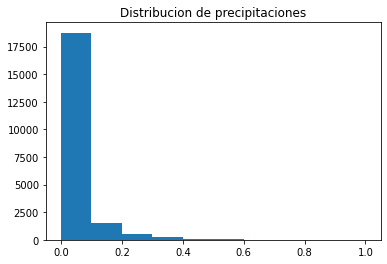

In [286]:
hist(clusterizedMMDIFS['precipitations'])
plt.title('Distribucion de precipitaciones')
plt.show()

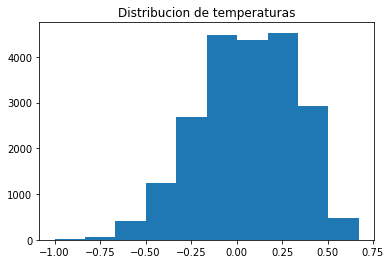

In [287]:
hist(clusterizedMMDIFS['temperatures'])
plt.title('Distribucion de temperaturas')
plt.show()

2. Primera derivada

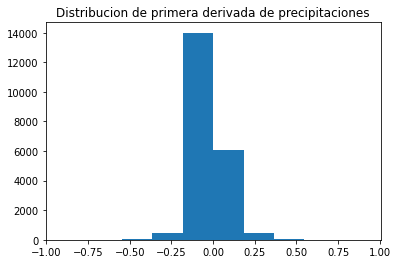

In [288]:
hist(clusterizedMMDIFS['precipitations 1nt derivative'].dropna())
plt.title('Distribucion de primera derivada de precipitaciones')
plt.show()

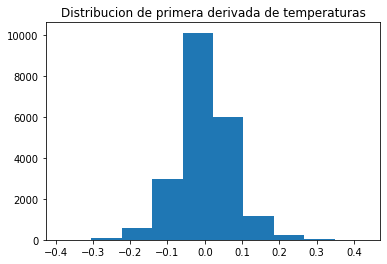

In [289]:
plt.hist(clusterizedMMDIFS['temperatures 1nt derivative'].dropna())
plt.title('Distribucion de primera derivada de temperaturas')
plt.show()

3. Segunda derivada

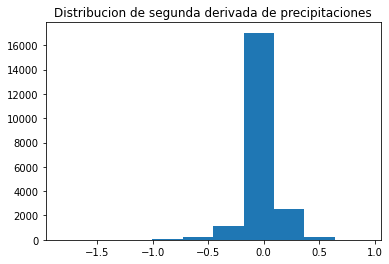

In [290]:
plt.hist(clusterizedMMDIFS['precipitations 2nt derivative'].dropna())
plt.title('Distribucion de segunda derivada de precipitaciones')
plt.show()

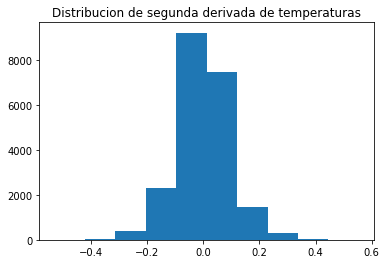

In [291]:
hist(clusterizedMMDIFS['temperatures 2nt derivative'].dropna())
plt.title('Distribucion de segunda derivada de temperaturas')
plt.show()

Graficas de linea
1. Baseline

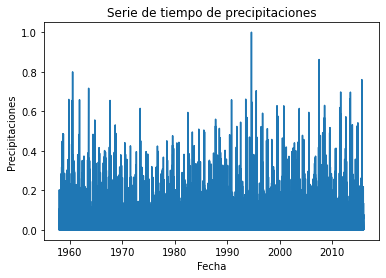

In [292]:
plt.plot(clusterizedMMDIFS['obs_dates'],
         clusterizedMMDIFS['precipitations'])
plt.xlabel('Fecha')
plt.ylabel('Precipitaciones')
plt.title('Serie de tiempo de precipitaciones')
plt.show()

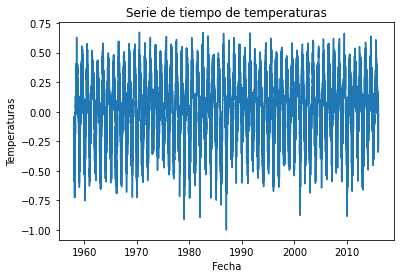

In [293]:
plt.plot(clusterizedMMDIFS['obs_dates'],
         clusterizedMMDIFS['temperatures'])
plt.xlabel('Fecha')
plt.ylabel('Temperaturas')
plt.title('Serie de tiempo de temperaturas')
plt.show()

2. Promedio movil semanal

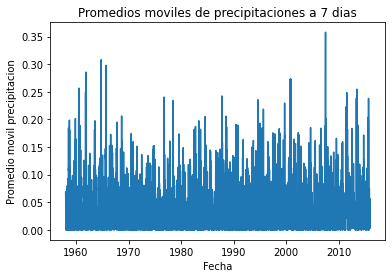

In [294]:
plt.plot(clusterizedMMDIFS['obs_dates'].loc[7:],
         clusterizedMMDIFS['precipitations MM 7 periods'].dropna())
plt.title('Promedios moviles de precipitaciones a 7 dias')
plt.xlabel('Fecha')
plt.ylabel('Promedio movil precipitacion')
plt.show()

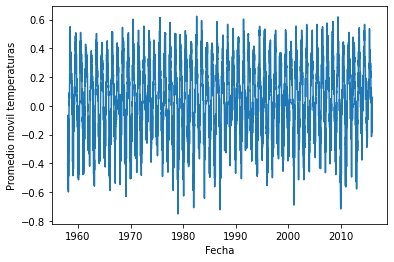

In [295]:
plt.plot(clusterizedMMDIFS['obs_dates'].loc[7:],
         clusterizedMMDIFS['temperatures MM 7 periods'].dropna())
plt.xlabel('Fecha')
plt.ylabel('Promedio movil temperaturas')
plt.show()

3. Promedio movil mensual

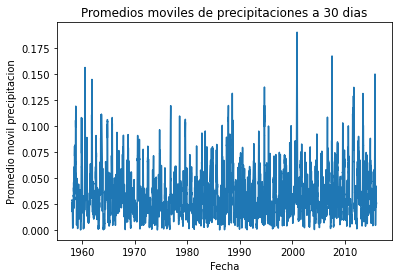

In [296]:
plt.plot(clusterizedMMDIFS['obs_dates'].loc[30:],
         clusterizedMMDIFS['precipitations MM 30 periods'].dropna())
plt.title('Promedios moviles de precipitaciones a 30 dias')
plt.xlabel('Fecha')
plt.ylabel('Promedio movil precipitacion')
plt.show()

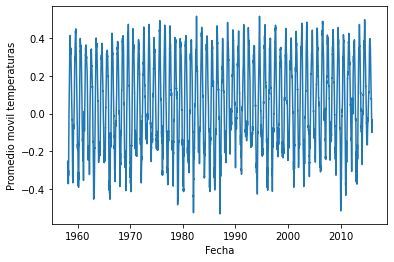

In [297]:
plt.plot(clusterizedMMDIFS['obs_dates'].loc[30:],
         clusterizedMMDIFS['temperatures MM 30 periods'].dropna())
plt.xlabel('Fecha')
plt.ylabel('Promedio movil temperaturas')
plt.show()

### Conclusiones: 
* Los promedios moviles sin dudas suavizan la serie de tiempo, reducen mucho la varianza
* Las derivadas discretas ayudan enormemente con las precipitaciones, y centran las temperaturas (aunque estas ya tenian un comportamiento mucho mejor que las precipitaciones en primer lugar)

¿Será esto suficiente?

Hagamos un analisis similar con la variable de salida

In [298]:
def finiteDifFlow(df: pd.DataFrame, order: int=1)-> pd.DataFrame:
  '''Calcula la n-esima derivada discreta de las columna target'''
  fDifs=np.diff(df['flow'].iloc[0:len(df)],order)
  col_name=str(order)+'nt derivative'
  df['flow '+col_name]=None
  df['flow '+col_name][order:len(df)]=fDifs
  return df

Obtengamos primera y segunda derivada

In [299]:
tesssssst=finiteDifFlow(clusterizedMMDIFS)
tesssssst=finiteDifFlow(tesssssst,2)
tesssssst

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,obs_dates,flow,temperatures,precipitations,temperatures MM 7 periods,precipitations MM 7 periods,temperatures MM 3 periods,precipitations MM 3 periods,temperatures MM 10 periods,precipitations MM 10 periods,temperatures MM 30 periods,precipitations MM 30 periods,temperatures 1nt derivative,precipitations 1nt derivative,temperatures 2nt derivative,precipitations 2nt derivative,flow 1nt derivative,flow 2nt derivative
0,1958-01-04,0.020185,-0.389269,0.000000,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,1958-01-05,0.011252,-0.237526,0.041093,None,None,None,None,None,None,None,None,0.151743,0.041093,None,None,-0.008933,None
2,1958-01-06,0.000012,-0.248804,0.202646,None,None,None,None,None,None,None,None,-0.011278,0.161552,-0.163021,0.120459,-0.01124,-0.002307
3,1958-01-07,0.000012,-0.311347,0.109171,None,None,-0.291866,0.081246,None,None,None,None,-0.062543,-0.093474,-0.051265,-0.255026,0.0,0.01124
4,1958-01-08,0.00371,-0.536910,0.054145,None,None,-0.265892,0.117637,None,None,None,None,-0.225564,-0.055026,-0.163021,0.038448,0.003698,0.003698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21173,2015-12-27,0.025493,-0.305878,0.008818,0.047798,0.013908,0.010481,0.016814,0.016234,0.019718,-0.031841,0.025379,-0.272044,0.008818,-0.170882,0.04709,-0.033844,-0.070677
21174,2015-12-28,0.057101,-0.316473,0.077601,-0.010399,0.014336,-0.090795,0.015697,0.006494,0.015873,-0.041365,0.025673,-0.010595,0.068783,0.261449,0.059965,0.031608,0.065452
21175,2015-12-29,0.058536,-0.289474,0.020282,-0.074504,0.025094,-0.218729,0.028807,-0.022522,0.018377,-0.055594,0.026678,0.026999,-0.057319,0.037594,-0.126102,0.001436,-0.030172
21176,2015-12-30,0.051861,-0.155502,0.054674,-0.124646,0.027866,-0.303942,0.035567,-0.057724,0.020406,-0.063876,0.024198,0.133971,0.034392,0.106972,0.091711,-0.006675,-0.008111


In [300]:
def movingMeansTarget(df: pd.DataFrame,periods: int) -> pd.DataFrame:
  '''Calcula el promedio movil a n periodos del flujo'''
  col_name='MM '+str(periods)+' periods'
  df['flow '+col_name]=None
  j=0
  for i in range(periods,len(df)):
    df['flow '+col_name][i]=df['flow'].iloc[j:i].mean()
    j+=1
  return df

In [301]:
tesssssst=movingMeansTarget(tesssssst,3)
tesssssst=movingMeansTarget(tesssssst,7)
tesssssst=movingMeansTarget(tesssssst,30)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [302]:
tesssssst

,obs_dates,flow,temperatures,precipitations,temperatures MM 7 periods,precipitations MM 7 periods,temperatures MM 3 periods,precipitations MM 3 periods,temperatures MM 10 periods,precipitations MM 10 periods,...,precipitations MM 30 periods,temperatures 1nt derivative,precipitations 1nt derivative,temperatures 2nt derivative,precipitations 2nt derivative,flow 1nt derivative,flow 2nt derivative,flow MM 3 periods,flow MM 7 periods,flow MM 30 periods
0,1958-01-04,0.020185,-0.389269,0.000000,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,1958-01-05,0.011252,-0.237526,0.041093,None,None,None,None,None,None,...,None,0.151743,0.041093,None,None,-0.008933,None,None,None,None
2,1958-01-06,0.000012,-0.248804,0.202646,None,None,None,None,None,None,...,None,-0.011278,0.161552,-0.163021,0.120459,-0.01124,-0.002307,None,None,None
3,1958-01-07,0.000012,-0.311347,0.109171,None,None,-0.291866,0.081246,None,None,...,None,-0.062543,-0.093474,-0.051265,-0.255026,0.0,0.01124,0.010483,None,None
4,1958-01-08,0.00371,-0.536910,0.054145,None,None,-0.265892,0.117637,None,None,...,None,-0.225564,-0.055026,-0.163021,0.038448,0.003698,0.003698,0.003758,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21173,2015-12-27,0.025493,-0.305878,0.008818,0.047798,0.013908,0.010481,0.016814,0.016234,0.019718,...,0.025379,-0.272044,0.008818,-0.170882,0.04709,-0.033844,-0.070677,0.041858,0.033184,0.034025
21174,2015-12-28,0.057101,-0.316473,0.077601,-0.010399,0.014336,-0.090795,0.015697,0.006494,0.015873,...,0.025673,-0.010595,0.068783,0.261449,0.059965,0.031608,0.065452,0.035778,0.035527,0.033643
21175,2015-12-29,0.058536,-0.289474,0.020282,-0.074504,0.025094,-0.218729,0.028807,-0.022522,0.018377,...,0.026678,0.026999,-0.057319,0.037594,-0.126102,0.001436,-0.030172,0.04731,0.040764,0.034204
21176,2015-12-30,0.051861,-0.155502,0.054674,-0.124646,0.027866,-0.303942,0.035567,-0.057724,0.020406,...,0.024198,0.133971,0.034392,0.106972,0.091711,-0.006675,-0.008111,0.047043,0.045263,0.035585


(array([1.5773e+04, 2.9080e+03, 1.2960e+03, 5.6800e+02, 3.1400e+02,
        1.4900e+02, 9.8000e+01, 4.5000e+01, 1.8000e+01, 6.0000e+00]),
 array([1.0179575729819122e-05, 0.09780165354072053, 0.19559312750571123,
        0.2933846014707019, 0.3911760754356926, 0.4889675494006833,
        0.586759023365674, 0.6845504973306648, 0.7823419712956554,
        0.8801334452606461, 0.9779249192256368], dtype=object),
 <a list of 10 Patch objects>)

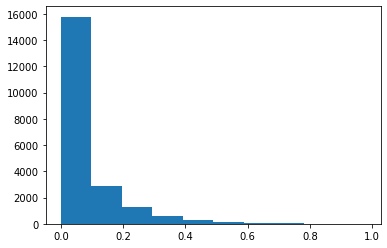

In [303]:
plt.hist(tesssssst['flow MM 3 periods'].dropna())

(array([1.5376e+04, 3.0350e+03, 1.4180e+03, 6.2100e+02, 3.4300e+02,
        1.7600e+02, 1.1600e+02, 5.2000e+01, 2.8000e+01, 6.0000e+00]),
 array([1.1709923664313391e-05, 0.09111517765378305, 0.18221864538390178,
        0.27332211311402055, 0.3644255808441393, 0.455529048574258,
        0.5466325163043767, 0.6377359840344954, 0.7288394517646142,
        0.819942919494733, 0.9110463872248517], dtype=object),
 <a list of 10 Patch objects>)

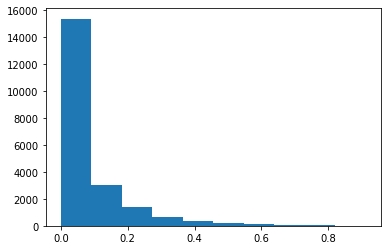

In [304]:
plt.hist(tesssssst['flow MM 7 periods'].dropna())

(array([11971.,  4127.,  2137.,  1246.,   667.,   476.,   280.,   123.,
           68.,    53.]),
 array([0.0020924416784267037, 0.05924395334363543, 0.11639546500884415,
        0.1735469766740529, 0.2306984883392616, 0.2878500000044703,
        0.3450015116696791, 0.4021530233348878, 0.4593045350000965,
        0.5164560466653052, 0.5736075583305139], dtype=object),
 <a list of 10 Patch objects>)

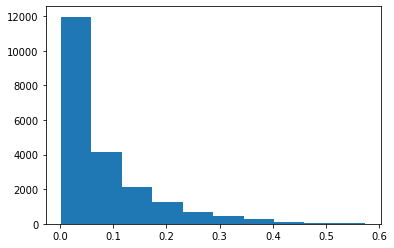

In [305]:
plt.hist(tesssssst['flow MM 30 periods'].dropna())

(array([  16.,   29.,  109.,  285., 1145., 4060., 8115., 5244., 1575.,
         360.,  137.,   58.,   30.,   14.]),
 array([-0.11511204989149801, -0.09775387249710615, -0.08039569510271428,
        -0.06303751770832242, -0.04567934031393056, -0.028321162919538706,
        -0.010962985525146837, 0.006395191869245032, 0.023753369263636886,
        0.04111154665802874, 0.058469724052420596, 0.07582790144681248,
        0.09318607884120433, 0.11054425623559619, 0.12790243362998807],
       dtype=object),
 <a list of 14 Patch objects>)

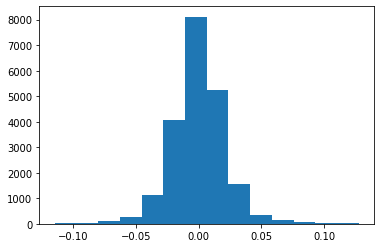

In [306]:
plt.hist(tesssssst['flow 1nt derivative'].dropna(),bins=int(np.log2(len(tesssssst))))

(array([3.000e+00, 3.200e+01, 2.980e+02, 1.803e+03, 5.853e+03, 8.386e+03,
        3.936e+03, 7.450e+02, 1.030e+02, 1.700e+01]),
 array([-0.14655064645902438, -0.11877957930730998, -0.09100851215559556,
        -0.06323744500388115, -0.03546637785216675, -0.007695310700452346,
        0.020075756451262083, 0.047846823602976485, 0.07561789075469089,
        0.10338895790640529, 0.1311600250581197], dtype=object),
 <a list of 10 Patch objects>)

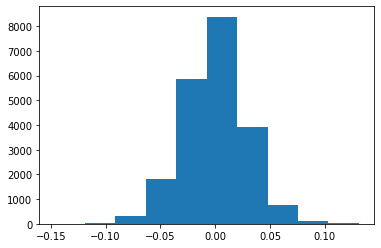

In [307]:
plt.hist(tesssssst['flow 2nt derivative'].dropna())

Propongo 2 ideas:
1. Cambiar target a promedios moviles
2. Cambiar target a derivada y escalar

## Cambiar target a promedios moviles

In [308]:
class resumen:
  '''Usada para estandarizar la validacion de modelos'''
  def __init__(self, historial: dict, modelo: keras.engine.sequential.Sequential,
              predicciones: ndarray):
    self.historial = historial
    self.modelo = modelo
    self.predicciones=predicciones

In [309]:
def regresor(df: pd.DataFrame, epochs_: int=500) -> resumen:
  X_train, X_test, y_train, y_test = train_test_split(
     df.drop(['obs_dates','flow','flow MM 3 periods',
              'flow MM 7 periods','flow MM 30 periods','flow 1nt derivative',
              	'flow 2nt derivative'],axis=1), 
     df[['flow MM 3 periods','flow MM 7 periods','flow MM 30 periods']], 
     test_size=0.2, 
     random_state=42)
  model = Sequential()
  model.add(Dense(1024,input_shape=(X_train.shape[1],),activation='linear'))
  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.1))
  model.add(Dense(3, activation='linear'))
  print('### Resumen del modelo ###')
  print(model.summary())
  X_train = np.asarray(X_train).astype('float32')
  X_test = np.asarray(X_test).astype('float32')
  y_train = np.asarray(y_train).astype('float32')
  y_test = np.asarray(y_test).astype('float32')

  model.compile(loss='mse', metrics=['mse','mae'],optimizer='adam')

  # early stopping callback
  # This callback will stop the training when there is no improvement in  
  # the validation loss for 10 consecutive epochs.  
  es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                    mode='min',
                                    patience=10, 
                                    restore_best_weights=True) 

  # now we just update our model fit call
  history = model.fit(X_test,
                      y_test,
                      callbacks=[es],
                      epochs=epochs_, # you can set this to a big number!
                      batch_size=100,
                      shuffle=True,
                      validation_split=0.2,
                      verbose=1)
  history_dict = history.history
  preds = model.predict(X_test) # see how the model did!

  rs=resumen(history_dict,model,preds)
  return rs

In [310]:
def perf_plotter(summary: resumen)-> None:
  ax=plt.figure()
  plt.plot(summary.historial['loss'],color='red',
           label='Perdida de entrenamiento')
  plt.plot(summary.historial['val_loss'],color='blue',
                      label='Perdida de validacion')
  plt.title('Perdida del modelo')
  plt.legend()
  plt.show()
  ax2=plt.figure()
  plt.plot(summary.historial['mse'],color='red',label='MSE entrenamiento')
  plt.plot(summary.historial['val_mse'],label='MSE validacion')
  plt.title('MSE del modelo')
  plt.legend()
  plt.show()
  ax3=plt.figure()
  plt.plot(summary.historial['mae'],color='red',label='MAE entrenamiento')
  plt.plot(summary.historial['val_mae'],label='MAE validacion')
  plt.title('MAE del modelo')
  plt.legend()
  plt.show()

In [311]:
r0=regresor(tesssssst.iloc[30:])

### Resumen del modelo ###
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 1024)              15360     
                                                                 
 dense_59 (Dense)            (None, 256)               262400    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_60 (Dense)            (None, 3)                 771       
                                                                 
Total params: 278,531
Trainable params: 278,531
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
34/34 [==============================] - 1s 14ms/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0599 - val_loss: 0.0053 - val_mse: 0.0053 -

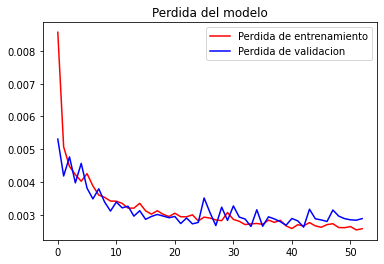

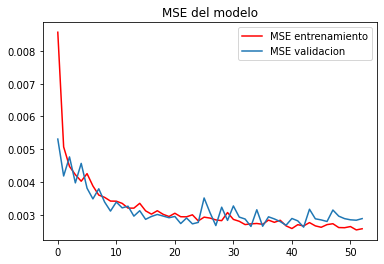

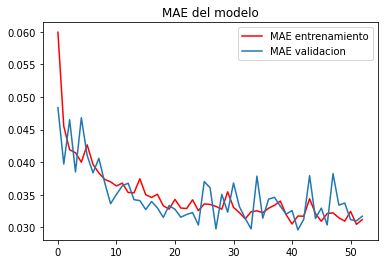

In [312]:
perf_plotter(r0)

In [313]:
final_eval_df=tesssssst.drop(['obs_dates','flow','flow MM 3 periods',
              'flow MM 7 periods','flow MM 30 periods','flow 1nt derivative',
              'flow 2nt derivative'],axis=1).values.astype('float32')

Tomo el ultimo año (arbitrario) para ver si realmente jala

In [314]:
def yearPredictionPlot(years: int=1)-> None:
  yPred=r0.modelo.predict(final_eval_df[-365*years:, :])
  yTrue=tesssssst['flow'].iloc[-365*years:]
  x=tesssssst['obs_dates'].iloc[-365*years:]  
  ax=plt.figure()
  plt.plot(x,yPred[:, 0],color='red',label='Prediccion')
  plt.plot(x,yTrue,color='blue',label='Flujo real')
  plt.title('Prediccion de promedio movil a 3 dias vs flujo real')
  plt.legend()
  plt.show()
  ax1=plt.figure()
  plt.plot(x,yPred[:, 1],color='red',label='Prediccion')
  plt.plot(x,yTrue,color='blue',label='Flujo real')
  plt.title('Prediccion de promedio movil a 7 dias vs flujo real')
  plt.legend()
  plt.show()
  ax2=plt.figure()
  plt.plot(x,yPred[:, 2],color='red',label='Prediccion')
  plt.plot(x,yTrue,color='blue',label='Flujo real')
  plt.title('Prediccion de promedio movil a 30 dias vs flujo real')
  plt.legend()
  plt.show()

In [315]:
def dayPredictionPlot(days: int=1)-> None:
  yPred=r0.modelo.predict(final_eval_df[-1*days:, :])
  yTrue=tesssssst['flow'].iloc[-1*days:]
  x=tesssssst['obs_dates'].iloc[-1*days:]  
  ax=plt.figure()
  plt.plot(x,yPred[:, 0],color='red',label='Prediccion')
  plt.plot(x,yTrue,color='blue',label='Flujo real')
  plt.title('Prediccion de promedio movil a 3 dias vs flujo real')
  plt.legend()
  plt.show()
  ax1=plt.figure()
  plt.plot(x,yPred[:, 1],color='red',label='Prediccion')
  plt.plot(x,yTrue,color='blue',label='Flujo real')
  plt.title('Prediccion de promedio movil a 7 dias vs flujo real')
  plt.legend()
  plt.show()
  ax2=plt.figure()
  plt.plot(x,yPred[:, 2],color='red',label='Prediccion')
  plt.plot(x,yTrue,color='blue',label='Flujo real')
  plt.title('Prediccion de promedio movil a 30 dias vs flujo real')
  plt.legend()
  plt.show()

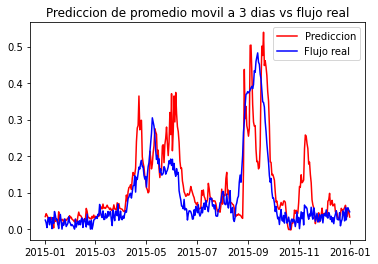

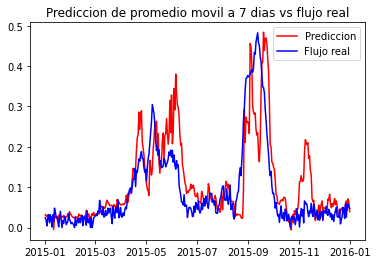

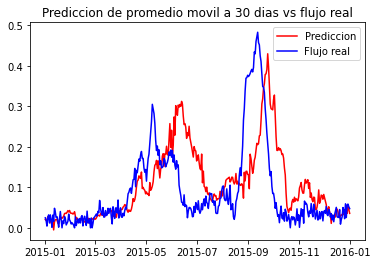

In [316]:
yearPredictionPlot()

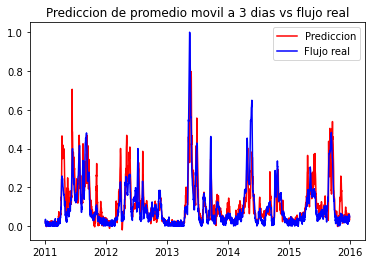

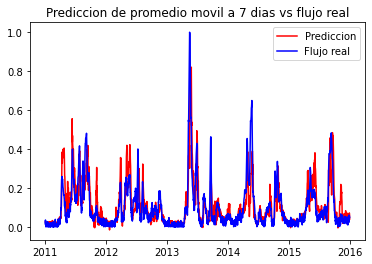

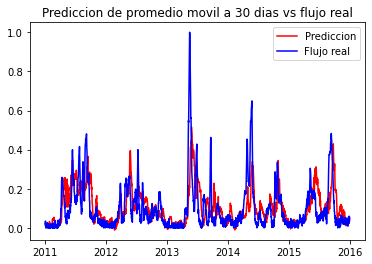

In [317]:
yearPredictionPlot(5)

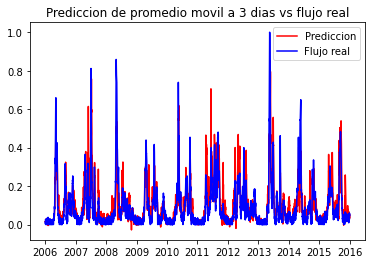

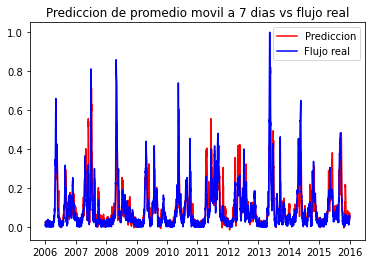

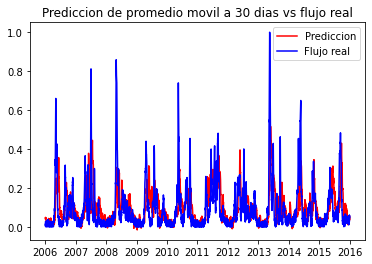

In [318]:
yearPredictionPlot(10)

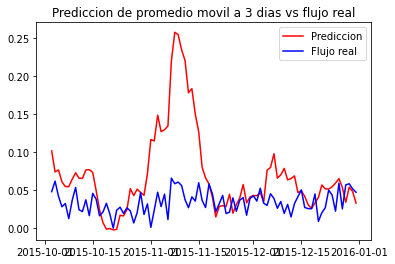

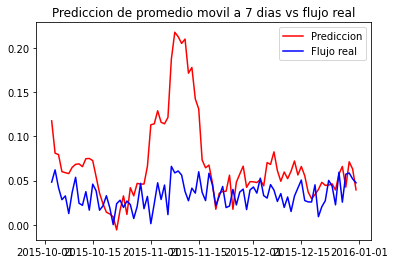

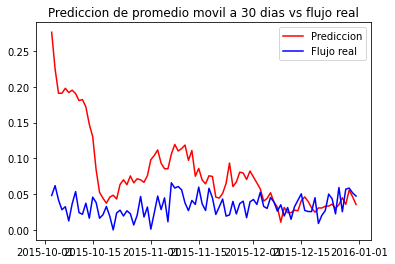

In [319]:
dayPredictionPlot(90)

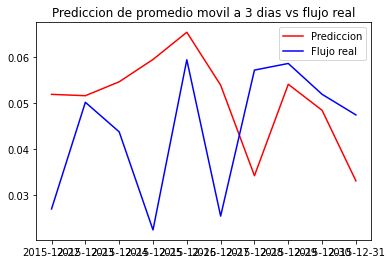

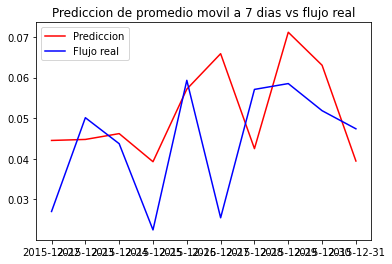

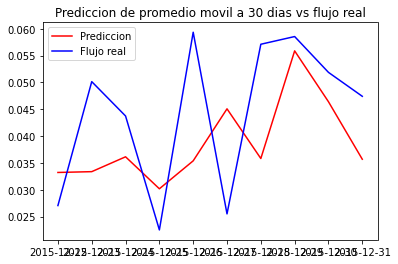

In [320]:
dayPredictionPlot(10)

In [321]:
yPred=r0.modelo.predict(final_eval_df[30:, :])
yTrue=tesssssst['flow'].iloc[30:]
x=tesssssst['obs_dates'].iloc[30:]  

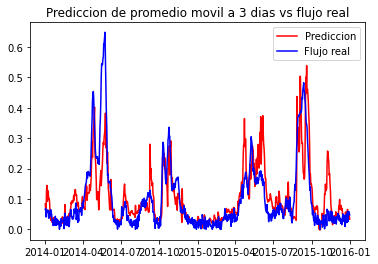

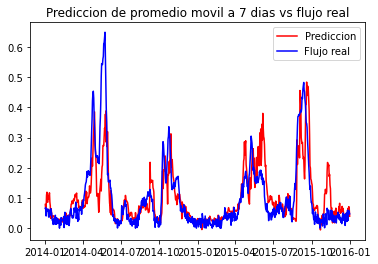

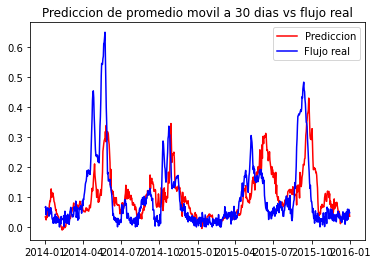

In [322]:
yearPredictionPlot(2)

Conclusiones: 

Se tiene un buen modelo, no es perfecto, pero a grandes rasgos comprende el comportamiento de la variable independiente. Podria evaluarse la posibilidad de ponderar las predicciones del vector de predicciones.
Para esta sesion:
$MSE=0.0026,MAE=0.0321$ Para flujo $\in[0,1]$
